# Population data for NYC, NYC counties, and Red Hook site

I took population data from the US Census using the American FactFinder portal in order to get population figures over time for NYC, its counties, and Red Hook (using the census tract values found in the geo_scope notebook - 53, 59, and 85). Other data sources had population figures for the years before 2010 or had estimates for each decade after 2000, but this seemed to be the best way to get population figures for each year.

## Libraries

In [1]:
import pandas as pd
import matplotlib.pylab as plt
import copy

## Getting the data

In [2]:
def df_maker(sort):
    dfs = []
    for i in range(10,18):
        # Dataframe with raw data
        df = pd.read_csv('data/primary_source_data/census_pop/ACS_{}_5YR_B01003_with_ann.csv'.format(i), \
                         skiprows=1)
        # Make dictionary
        pop_dict = {'New York County': 0, 'Kings County': 0, 'Bronx County': 0, 'Queens County': 0, \
                    'Richmond County': 0, 'New York City Total': 0, 'Red Hook CTs': 0}
        # Get populations for each county and the whole city
        total_pop = 0
        for k, v in pop_dict.items():
            pop = df[df['Geography'].str.contains(k)]['Estimate; Total'].sum()
            pop_dict[k] = pop
            total_pop += pop
        pop_dict['New York City Total'] = total_pop

        # Get Red Hook populations
        rh_tracts = [' 53,', ' 59,', ' 85,']
        rh_pop = 0
        for tract in rh_tracts:
            tract_pop = df[(df['Geography'].str.contains(tract)) & (df['Geography'].str.contains('Kings'))]\
                ['Estimate; Total'].sum()
            rh_pop += tract_pop
        pop_dict['Red Hook CTs'] = rh_pop
        
        # Create a dataframe for all the populations
        pop_df = pd.DataFrame.from_dict(pop_dict, orient='index', columns=['20{}'.format(i)])
        pop_df.reset_index(level=0, inplace=True)
        pop_df.rename(columns={'index':'Geography'}, inplace=True)
        dfs.append(pop_df)
    
    combined_df = copy.deepcopy(dfs[0])
    for i in range(1, len(dfs)):
        combined_df = combined_df.merge(dfs[i], how='left', left_on='Geography', right_on='Geography')
        
    return combined_df

In [3]:
pop_df = df_maker(sort=False)
pop_df

,Geography,2010,2011,2012,2013,2014,2015,2016,2017
0,New York County,1583345,1588257,1596735,1605272,1618398,1629507,1634989,1653877
1,Kings County,2466782,2486119,2512740,2539789,2570801,2595259,2606852,2635121
2,Bronx County,1365725,1374593,1386364,1397315,1413566,1428357,1436785,1455846
3,Queens County,2199169,2213977,2235008,2256400,2280602,2301139,2310011,2339280
4,Richmond County,463450,466034,468374,470223,471522,472481,473324,475948
5,New York City Total,8078471,8128980,8199221,8268999,8354889,8426743,8461961,8560072
6,Red Hook CTs,10973,11374,10987,10670,10440,10768,11102,11316


In [4]:
# Transformation for merging in other notebooks
pop_df = pop_df.T.reset_index()
pop_df.columns = pop_df.iloc[0]
pop_df = pop_df.reindex(pop_df.index.drop(0))
pop_df.rename(columns={'Geography':'Year'}, inplace=True)
pop_df

,Year,New York County,Kings County,Bronx County,Queens County,Richmond County,New York City Total,Red Hook CTs
1,2010,1583345,2466782,1365725,2199169,463450,8078471,10973
2,2011,1588257,2486119,1374593,2213977,466034,8128980,11374
3,2012,1596735,2512740,1386364,2235008,468374,8199221,10987
4,2013,1605272,2539789,1397315,2256400,470223,8268999,10670
5,2014,1618398,2570801,1413566,2280602,471522,8354889,10440
6,2015,1629507,2595259,1428357,2301139,472481,8426743,10768
7,2016,1634989,2606852,1436785,2310011,473324,8461961,11102
8,2017,1653877,2635121,1455846,2339280,475948,8560072,11316


In [5]:
# Export to csv
# pop_df.to_csv('data/created_data/pop_time.csv', index=False)

## Plotting

In [10]:
# Get specific df columns for the plot at the end
cols_filter = pop_df.columns.drop(['Year','Bronx County','Queens County','Richmond County','New York County'])
cols_filter

Index(['Kings County', 'New York City Total', 'Red Hook CTs'], dtype='object', name=0)

In [11]:
# Get the years for the following merge
years = pop_df[['Year']]
years

,Year
1,2010
2,2011
3,2012
4,2013
5,2014
6,2015
7,2016
8,2017


In [12]:
# Percentage change in population
pc = pop_df[cols_filter].pct_change().drop([1]).reset_index(drop=True)
pc = pc.merge(years.drop([1]).reset_index(drop=True), how='left', left_index=True, right_index=True)
pc

,Kings County,New York City Total,Red Hook CTs,Year
0,0.007839,0.006252,0.036544,2011
1,0.010708,0.008641,-0.034025,2012
2,0.010765,0.008510,-0.028852,2013
3,0.012210,0.010387,-0.021556,2014
4,0.009514,0.008600,0.031418,2015
5,0.004467,0.004179,0.031018,2016
6,0.010844,0.011594,0.019276,2017


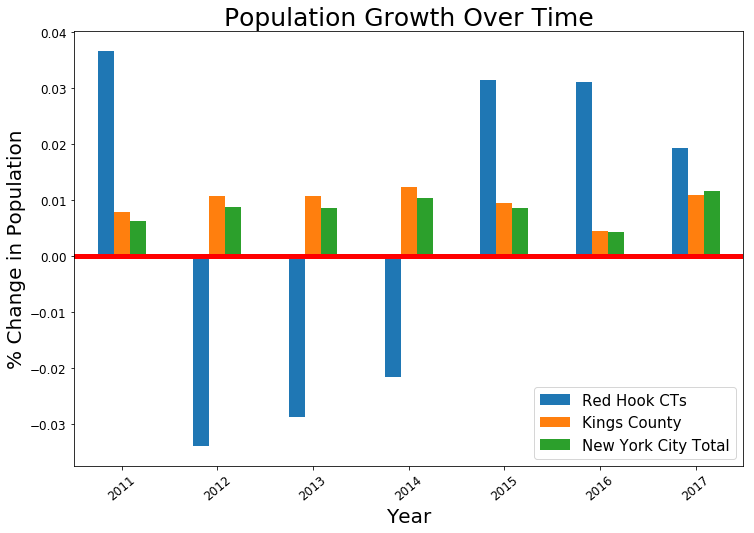

In [15]:
# Plot
f, ax = plt.subplots(figsize=(12,8))
pc.plot(x="Year", y=["Red Hook CTs", "Kings County", "New York City Total"], kind="bar", ax=ax)
ax.axhline(0, color='red', lw=5)
plt.title("Population Growth Over Time", fontsize=25)
plt.xlabel("Year", fontsize=20)
plt.ylabel("% Change in Population", fontsize=20)
plt.xticks(fontsize=12, rotation=40)
plt.yticks(fontsize=12)
plt.legend(fontsize=15)
plt.show()